In [ ]:
###### Another Vector Autoregressive (VAR) Approach ############

In [35]:
# loading essential libraries first
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

In [36]:
# data
dt = pd.read_excel('Time series data_new.xlsx', index_col='Date', parse_dates= True)
dt.head()

,No of Patients,Pandemic Effect,Avg Temp,Humidity,Wind speed,Temp
Date,,,,,,
2019-01-01,259,0,32.0,78.8,8.6,273.150000
2019-01-02,322,0,30.4,84.0,8.0,272.261111
2019-01-03,295,0,32.9,69.0,12.8,273.650000
2019-01-04,293,0,37.3,68.9,7.5,276.094444
2019-01-05,277,0,38.7,73.5,5.9,276.872222


In [37]:
dt1 = dt[["No of Patients", "Temp", "Humidity"]]

In [38]:
dt1

,No of Patients,Temp,Humidity
Date,,,
2019-01-01,259,273.150000,78.8
2019-01-02,322,272.261111,84.0
2019-01-03,295,273.650000,69.0
2019-01-04,293,276.094444,68.9
2019-01-05,277,276.872222,73.5
...,...,...,...
2020-12-27,186,273.205556,74.5
2020-12-28,241,274.816667,67.8
2020-12-29,206,270.650000,68.0


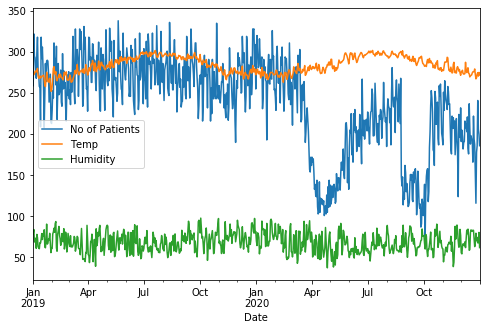

In [40]:
# Visualize the data
dt1.plot(figsize =(8,5))

In [ ]:
# Temperature shows an increase during the summer months and a decrease during the winter months
# Humidity shows some stationarity across the two years

In [41]:
# Checking stationarity
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(dt1['No of Patients'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -1.8747551755779241
p-value: 0.3440286550181293


In [42]:
adfuller_test = adfuller(dt1['Temp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -1.6165161411006141
p-value: 0.4745562177066794


In [43]:
adfuller_test = adfuller(dt1['Humidity'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -9.955558952805182
p-value: 2.44959210906423e-17


In [ ]:
# Comments
# For all three cases, the p-value is not significant enough, meaning that we can not reject the null hypothesis and conclude 
# that the series are non-stationary.

In [44]:
data_d = dt1.diff().dropna()

In [45]:
adfuller_test = adfuller(data_d['No of Patients'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.267354120216686
p-value: 4.083157627356927e-08


In [46]:
adfuller_test = adfuller(data_d['Temp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -11.115296798713072
p-value: 3.5756518080961644e-20


In [47]:
adfuller_test = adfuller(data_d['Humidity'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -11.866670339239953
p-value: 6.650469779950319e-22


In [ ]:
# The p-value shows that our variables are stationary and we can reject H0

In [48]:
# Model Building
train = data_d.iloc[:710]
test = data_d.iloc[710:]

In [49]:
# Search for optimal parameter using a grid search approach to find the smallest AIC scores
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/Users/egbeetuetu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


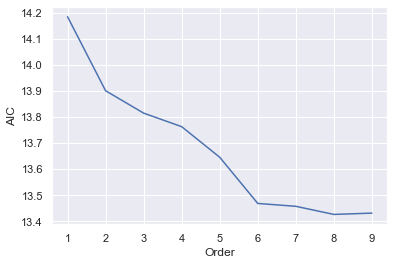

In [51]:
# Visualize the AIC scores 
import seaborn as sns
import numpy as np
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [ ]:
# The plot shows a decreasing trend for the AIC scores. The lowest AIC score is achieved at the order of 8
# We select 8 as the optimal order of the VAR model and fit it to the forecasting model

In [52]:
results = forecasting_model.fit(8)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Feb, 2021
Time:                     17:27:50
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    13.9127
Nobs:                     702.000    HQIC:                   13.6142
Log likelihood:          -7625.87    FPE:                    677556.
AIC:                      13.4262    Det(Omega_mle):         610033.
--------------------------------------------------------------------
Results for equation No of Patients
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.325463         0.903062           -0.360           0.719
L1.No of Patients        -0.565473         0.038065          -14.856           0.000
L1.Temp                   0.929632 

In [70]:
# Forecasting
train.values[-2:]

array([[-9.        , -1.94444444, 10.5       ],
       [18.        ,  3.77777778, -4.3       ]])

In [71]:
# After fitting the model, we forecast for the test data where the last 8 days of the training data is set as lagged values
# We set the steps as 21 days since we want to forecast for the next 21 days 

In [73]:
lagged_values = train.values[-8:]

forecast = pd.DataFrame(results.forecast(y=lagged_values, steps=20), index = test.index, columns = ['No of Patients_1d', 'Temp_1d', 
                                                                                                    'Humidity_1d'])
forecast

,No of Patients_1d,Temp_1d,Humidity_1d
Date,,,
2020-12-12,-10.966608,-0.366261,-9.282380
2020-12-13,-3.712936,-0.943949,1.519147
2020-12-14,12.313224,-0.433281,-2.731768
2020-12-15,-12.977853,-0.141318,1.458183
2020-12-16,1.085713,-0.218036,4.374987
2020-12-17,8.657199,1.602675,-3.269592
2020-12-18,1.453130,-0.007641,0.338184
2020-12-19,-7.260500,-0.555365,2.067619
2020-12-20,-2.504085,-0.092995,-0.478843


In [74]:
# We need to invert the data from the differenced form to it original form

In [75]:
# Inverting
forecast['No of Patients_forecasted'] = dt1["No of Patients"].iloc[-10-1] + data_d['No of Patients'].cumsum()
#forecast['Temp_forecasted'] = dt1["Temp"].iloc[-20-1] + data_d['Temp_1d'].cumsum()
#forecast['Humidity_forecasted'] = dt1["Humidity"].iloc[-20-1] + data_d['Humidity_1d'].cumsum()

In [84]:
forecast['No of Patients_forecasted']

Date
2020-12-12    146.0
2020-12-13    139.0
2020-12-14    200.0
2020-12-15    170.0
2020-12-16    151.0
2020-12-17    161.0
2020-12-18    157.0
2020-12-19    156.0
2020-12-20    129.0
2020-12-21    185.0
2020-12-22    157.0
2020-12-23    150.0
2020-12-24    114.0
2020-12-25     79.0
2020-12-26    141.0
2020-12-27    149.0
2020-12-28    204.0
2020-12-29    169.0
2020-12-30    163.0
2020-12-31    149.0
Name: No of Patients_forecasted, dtype: float64

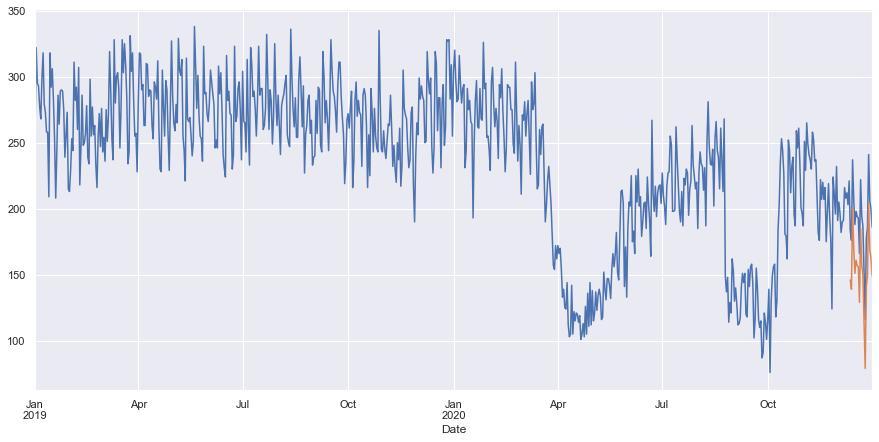

In [97]:
dt['No of Patients'].plot(figsize=(15,7))
forecast['No of Patients_forecasted'].plot();

In [99]:
# Calculate Mean Squared Error
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
z = (mean_squared_error(dt1['No of Patients'][-20:], forecast['No of Patients_forecasted']))

In [100]:
z

1369.0

In [ ]:
# RMSE = 37